<a href="https://colab.research.google.com/github/imtisalrangrez/MLlab_180/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (569, 30)
Class distribution: [212 357]

RandomForest results:
  accuracy: 0.9561
  precision: 0.9589
  recall: 0.9722
  f1: 0.9655
  roc_auc: 0.9939

GradBoost(sklearn) results:
  accuracy: 0.9561
  precision: 0.9467
  recall: 0.9861
  f1: 0.9660
  roc_auc: 0.9907

XGBoost results:
  accuracy: 0.9561
  precision: 0.9467
  recall: 0.9861
  f1: 0.9660
  roc_auc: 0.9901
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best params (GridSearch): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}

TunedModel results:
  accuracy: 0.9561
  precision: 0.9467
  recall: 0.9861
  f1: 0.9660
  roc_auc: 0.9901

Tuned+SMOTE (eval on test) results:
  accuracy: 0.9474
  precision: 0.9459
  recall: 0.9722
  f1: 0.9589
  roc_auc: 0.9924

RF_class_weighted results:
  accuracy: 0.9474
  precision: 0.9583
  recall: 0.9583
  f1: 0.9583
  roc_auc: 0.9937

Summary results:
                 model  accuracy  precision    recall  

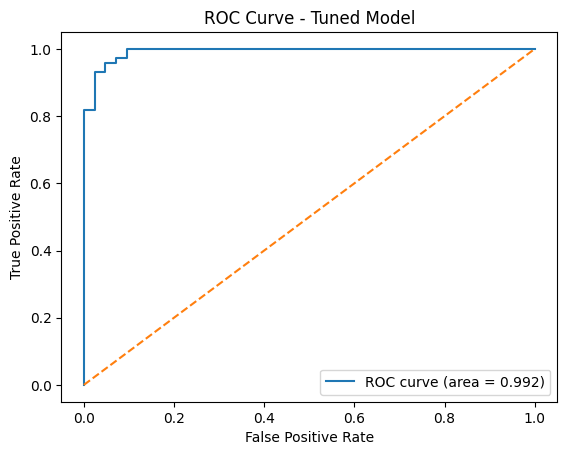

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

try:
    import optuna
    OPTUNA_AVAILABLE = True
except Exception:
    OPTUNA_AVAILABLE = False

data = load_breast_cancer(as_frame=True)
X = data.data
y = data.target
feature_names = data.feature_names

print("Dataset shape:", X.shape)
print("Class distribution:", np.bincount(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradBoost(sklearn)": GradientBoostingClassifier(random_state=42),
}

if XGB_AVAILABLE:
    models["XGBoost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

def evaluate_model(clf, Xtr, Xte, ytr, yte, name="model"):
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)
    probs = clf.predict_proba(Xte)[:,1] if hasattr(clf, "predict_proba") else None
    res = {
        "accuracy": accuracy_score(yte, preds),
        "precision": precision_score(yte, preds),
        "recall": recall_score(yte, preds),
        "f1": f1_score(yte, preds),
        "roc_auc": roc_auc_score(yte, probs) if probs is not None else None
    }
    print(f"\n{name} results:")
    for k,v in res.items():
        print(f"  {k}: {v:.4f}")
    return res

baseline_results = {}
for name, clf in models.items():
    baseline_results[name] = evaluate_model(clf, X_train_scaled, X_test_scaled, y_train, y_test, name=name)

# 5) Research gap experiments:
#    a) Hyperparameter tuning for a strong model (XGBoost if available else HistGradientBoosting)
#    b) Handling class imbalance: class_weight and SMOTE

if XGB_AVAILABLE:
    model_to_tune = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
else:
    model_to_tune = HistGradientBoostingClassifier(random_state=42)

param_grid = {
}
if XGB_AVAILABLE:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }
else:
    param_grid = {
        'max_iter': [100, 200],
        'max_leaf_nodes': [15, 31, 63],
        'learning_rate': [0.01, 0.1],
    }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(model_to_tune, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

print("\nBest params (GridSearch):", grid.best_params_)
best_model = grid.best_estimator_
tuned_results = evaluate_model(best_model, X_train_scaled, X_test_scaled, y_train, y_test, name="TunedModel")

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)
best_model_sm = grid.best_estimator_.fit(X_train_sm, y_train_sm)
tuned_sm_results = evaluate_model(best_model_sm, X_train_sm, X_test_scaled, y_train_sm, y_test, name="Tuned+SMOTE (eval on test)")

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: cw[0], 1: cw[1]}
rf_with_cw = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
cw_res = evaluate_model(rf_with_cw, X_train_scaled, X_test_scaled, y_train, y_test, name="RF_class_weighted")

rows = []
for name, res in baseline_results.items():
    row = {'model': name, **res}
    rows.append(row)

rows.append({'model': 'TunedModel', **tuned_results})
rows.append({'model': 'Tuned+SMOTE', **tuned_sm_results})
rows.append({'model': 'RF_class_weighted', **cw_res})

results_df = pd.DataFrame(rows)
print("\nSummary results:\n", results_df)

results_df.to_csv("results_summary.csv", index=False)
import joblib
joblib.dump(best_model, "best_model.pkl")

if hasattr(best_model, "predict_proba"):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    probs = best_model.predict_proba(X_test_scaled)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Tuned Model')
    plt.legend()
    plt.savefig("roc_curve_tuned_model.png")
    plt.show()
